<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_7_DCGAN_SAGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title INSTALLS
!pip install livelossplot --quiet

In [13]:
#@title IMPORTS
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import tqdm.notebook as nb
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import CelebA as DS  #other options CIFAR10, STL10
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from IPython.display import clear_output
from livelossplot import PlotLosses

In [68]:
#@title IMAGE HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):
  x = x.clamp(0, 1)
  return x
  
def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y, cols=5):
  with torch.no_grad():  
    images = images.cpu()
    images = to_img(images)
    rows = int(len(images)/cols) +1
    np_imagegrid = make_grid(images,cols,rows).numpy()
    figure(figsize=(x,y))
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

In [74]:
#@title HYPERPARAMETERS
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=200,
                     batch_size=64,
                     lr=.002,
                     b1=.5,
                     b2=0.999,
                     n_cpu=8,
                     latent_dim=100,
                     img_size=64,
                     channels=3,                     
                     sample_interval=400)

print(hp.lr)

0.002


In [5]:
#@title SETUP DATA FOLDERS
dataset_name = "celeba" 
dataset_url = 'https://www.dropbox.com/s/kgqofw91l8m1mk6/celeba.zip?dl=1'
img_root_folder = 'data'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed data/celeba


In [6]:
#@title DOWNLOAD IMAGES
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/kgqofw91l8m1mk6/celeba.zip?dl=1


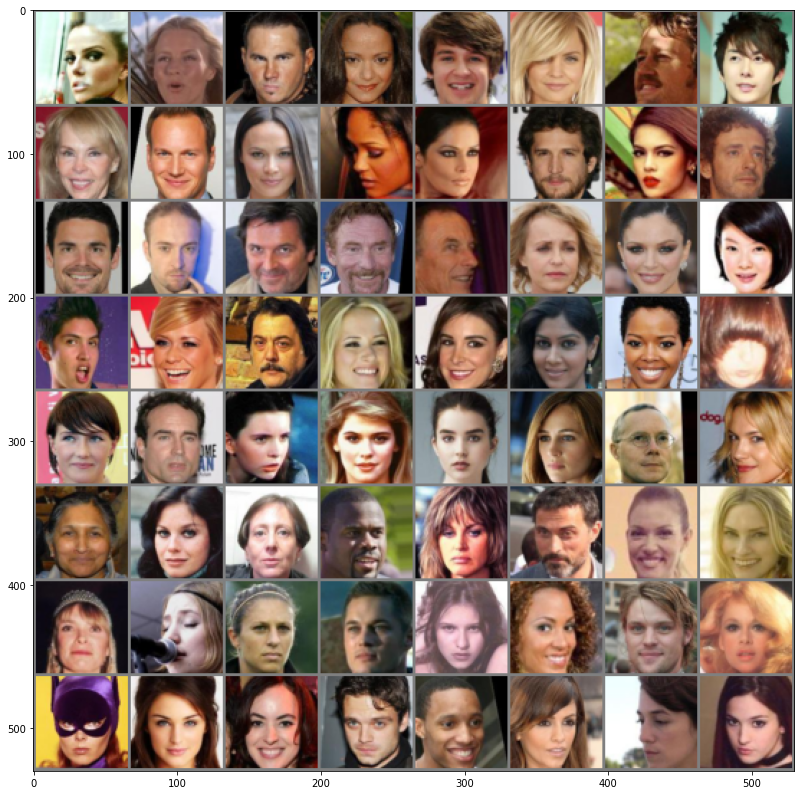

In [96]:
#@title LOAD IMAGES
transform=transforms.Compose([
                               transforms.Resize(int(hp.img_size*1.25)),
                               transforms.CenterCrop(hp.img_size),
                               transforms.Resize(hp.img_size),                               
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_dataset = datasets.ImageFolder('./data/', transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(make_grid(images),14)

In [26]:
#@title TENSOR HELPERS
def tensor2var(x, grad=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=grad)

def var2tensor(x):
    return x.data.cpu()

def var2numpy(x):
    return x.data.cpu().numpy()

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

In [16]:
#@title SPECTRAL NORMALIZATION
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [100]:
#@title SELF ATTENTION & MODELS
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        #inside forward function
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size=64, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 512, 'relu')
        self.attn2 = Self_Attn( 256, 'relu')
        self.attn3 = Self_Attn( 128, 'relu')
        self.attn4 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out,_ = self.attn1(out)
        out=self.l2(out)
        out,_ = self.attn2(out)
        out=self.l3(out)        
        out,p1 = self.attn3(out)        
        out=self.l4(out)
        out,p2 = self.attn4(out)
        out=self.last(out)

        return out, p1, p2


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(64, 'relu')
        self.attn2 = Self_Attn(128, 'relu')
        self.attn3 = Self_Attn(256, 'relu')
        self.attn4 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out,_ = self.attn1(out)
        out = self.l2(out)
        out,_ = self.attn2(out)
        out = self.l3(out)        
        out,p1 = self.attn3(out)
        out=self.l4(out)        
        out,p2 = self.attn4(out)
        out=self.last(out)

        return out.squeeze(), p1, p2

In [101]:
#@title MODELS AND OPTIMIZERS 
generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
  generator.cuda()
  discriminator.cuda()
  loss_fn.cuda()

In [102]:
#@title OPTIMIZERS AND TENSOR SETUP
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

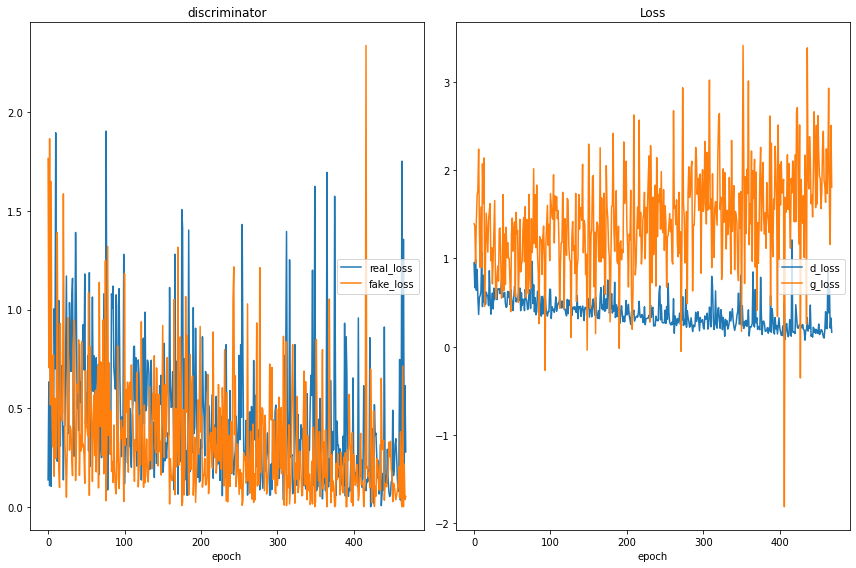

discriminator
	real_loss        	 (min:    0.000, max:    1.905, cur:    0.278)
	fake_loss        	 (min:    0.000, max:    2.339, cur:    0.052)
Loss
	d_loss           	 (min:    0.075, max:    1.210, cur:    0.165)
	g_loss           	 (min:   -1.812, max:    3.413, cur:    1.807)
Epoch: 14


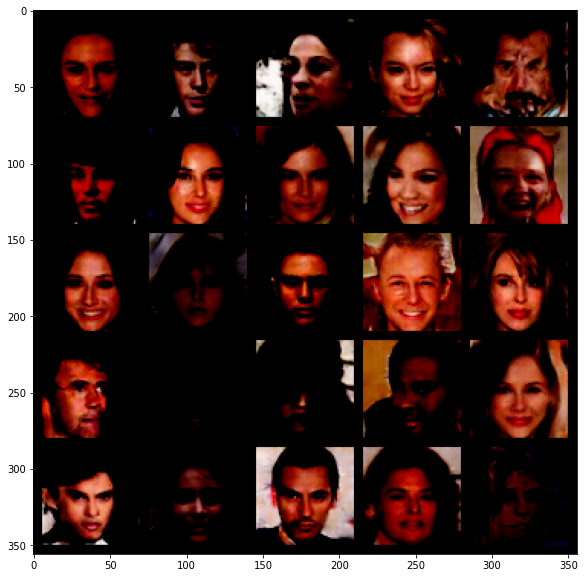

In [ ]:
#@title TRAINING
groups = {'loss': ['d_loss', 'g_loss'], 'discriminator': ['real_loss', 'fake_loss']}
liveloss = PlotLosses(groups=groups)
history={ }
for epoch in range(hp.n_epochs):  
  for i, (imgs, _) in enumerate(train_loader):

      # Adversarial ground truths
      valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_images = Variable(imgs.type(Tensor))

      # ---------------------
      #  Train Discriminator
      # ---------------------
      optimizer_D.zero_grad()

      d_out_real,dr1,dr2 = discriminator(real_images)
      #hinge loss
      d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()      
      
      z = tensor2var(torch.randn(real_images.size(0), hp.latent_dim))
      fake_images,gf1,gf2 = generator(z)
      d_out_fake,df1,df2 = discriminator(fake_images)

      #hinge loss
      d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()      

      # Backward + Optimize
      d_loss = (d_loss_real + d_loss_fake) / 2
            
      d_loss.backward()
      optimizer_D.step()

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      z = tensor2var(torch.randn(real_images.size(0), hp.latent_dim))
      fake_images,_,_ = generator(z)

      g_out_fake,_,_ = discriminator(fake_images)  # batch x n           
      g_loss = - g_out_fake.mean()
      
      g_loss.backward()
      optimizer_G.step()      
      
      history['d_loss'] = d_loss.item()
      history['g_loss'] = g_loss.item() 
      history['real_loss'] = d_loss_real
      history['fake_loss'] = d_loss_fake      

      batches_done = epoch * len(train_loader) + i
      if batches_done % sample_interval == 0:        
        liveloss.update(history)
        liveloss.send()
        print(f"Epoch: {epoch}")
        visualise_output(fake_images.data[:25],10, 10)          